In [1]:
from preprocessed_mnist import load_dataset
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html
import matplotlib.pyplot as plt

x_train, y_train, X_val, y_val, x_test, y_test = load_dataset()

Using TensorFlow backend.


(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)


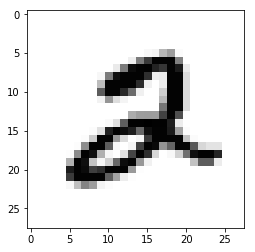

In [2]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

%matplotlib inline
plt.imshow(x_train[5], cmap="Greys");

In [17]:
# set tensorflow session
s = tf.InteractiveSession()

# Begin with logistic regression from the previous assignment to classify some number against others (e.g. zero vs nonzero)

## 1.data process

In [4]:
Y_train = [int(y == 0) for y in y_train]
Y_test = [int(y == 0) for y in y_test]
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])
#print(X_train.shape)

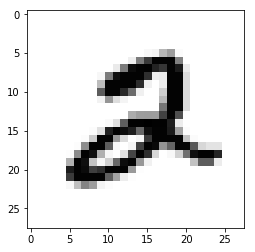

In [5]:
# test the result of dimension reducing
plt.imshow(X_train[5].reshape(28,28), cmap="Greys");

## 2.Logistic regression model

In [6]:
# set parameters
input_X = tf.placeholder(tf.float32, shape = (None,X_train.shape[1]))
input_y = tf.placeholder(tf.float32, shape = (None))

weights = tf.Variable(tf.random_normal([X_train.shape[1],1]))
b = tf.Variable(0, dtype= tf.float32)

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can  get rid of them with tf.squeeze .
# Don't forget the sigmoid.
# predicted_y = <predicted probabilities for input_X>
predicted_y = tf.squeeze(tf.sigmoid(tf.matmul(input_X, weights) + b))

# Loss. Should be a scalar number - average loss over all the objects
# tf.reduce_mean is your friend here
# loss = <logistic loss (scalar, mean over sample)>
#loss = tf.reduce_mean((predicted_y-input_y)**2)
loss = -tf.reduce_mean(input_y*tf.log(tf.clip_by_value(predicted_y,1e-10,1.0))+ 
                      (1-input_y)*tf.log(tf.clip_by_value(1-predicted_y,1e-10,1.0)))
# See above for an example. tf.train.*Optimizer
# optimizer = <optimizer that minimizes loss>
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss)

## 3.Training the model

In [7]:
# init varables
s.run(tf.global_variables_initializer())


for i in range(500):
    s.run(optimizer, {input_X: X_train, input_y: Y_train})
    if i % 50 == 0:
        loss_i = s.run(loss, {input_X: X_train, input_y: Y_train})
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train auc:", roc_auc_score(Y_train, s.run(predicted_y, {input_X:X_train})))
        print("test auc:", roc_auc_score(Y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:2.4017
train auc: 0.481640795875
test auc: 0.465262907824
loss at iter 50:1.0437
train auc: 0.533447832296
test auc: 0.526848613059
loss at iter 100:0.8540
train auc: 0.61316181285
test auc: 0.609065512014
loss at iter 150:0.7234
train auc: 0.688157819155
test auc: 0.685207362324
loss at iter 200:0.6231
train auc: 0.749631733836
test auc: 0.747486311598
loss at iter 250:0.5459
train auc: 0.796742654031
test auc: 0.79539085479
loss at iter 300:0.4860
train auc: 0.831979172988
test auc: 0.831574279379
loss at iter 350:0.4390
train auc: 0.858365170418
test auc: 0.858704805647
loss at iter 400:0.4011
train auc: 0.878358662635
test auc: 0.879304210598
loss at iter 450:0.3705
train auc: 0.893777860486
test auc: 0.895304199285


# Generalize it to multiclass logistic regression. Either try to remember the week 1 lectures or google it.

## 1.data process

In [8]:
#X_test,X_train are same as below

# do one hot encoding for y
Y_train = s.run(tf.one_hot(y_train,depth=10))
Y_test = s.run(tf.one_hot(y_test,depth=10))

## 2.Softmax model

In [9]:
# num of output
output_num = 10

# set parameters
input_X = tf.placeholder(tf.float32, shape = (None,X_train.shape[1]))
input_y = tf.placeholder(tf.float32, shape = (None,output_num))

weights = tf.Variable(tf.random_normal([X_train.shape[1],output_num]))
b = tf.Variable(tf.random_normal([1,output_num]))

predicted_y = tf.nn.softmax(tf.matmul(input_X, weights) + b)
print(predicted_y)
## define the cross entroy loss
loss = -tf.reduce_mean(input_y* tf.log(tf.clip_by_value(predicted_y, 1e-10, 1.0)))
print(loss)
## difine optimizer
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss)

Tensor("Softmax:0", shape=(?, 10), dtype=float32)
Tensor("Neg_1:0", shape=(), dtype=float32)


## 3.Training Model

In [10]:
# init varables
s.run(tf.global_variables_initializer())

# number of iteration
STEPS = 5000
batch_size = 1000
dataset_size = X_train.shape[0] #50000
for i in range(STEPS):
    
    # batch gradient descent
    start = (i * batch_size) % dataset_size
    end = min(start + batch_size, dataset_size)
    s.run(optimizer, {input_X: X_train[start:end], input_y: Y_train[start:end]})
    
    # print the loss in the training process
    if i % 1000 == 0:
        loss_i = s.run(loss, {input_X: X_train, input_y: Y_train})
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train auc:", roc_auc_score(Y_train, s.run(predicted_y, {input_X:X_train})))
        print("test auc:", roc_auc_score(Y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:1.2333
train auc: 0.49475201078
test auc: 0.49528643575
loss at iter 1000:0.9637
train auc: 0.574702563866
test auc: 0.575587623667
loss at iter 2000:0.7802
train auc: 0.642055298503
test auc: 0.643915341373
loss at iter 3000:0.6251
train auc: 0.698702589431
test auc: 0.701454446362
loss at iter 4000:0.5172
train auc: 0.746743830775
test auc: 0.750119997962


# Add a hidden layer.

## 1. data process

In [11]:
Y_train = s.run(tf.one_hot(y_train,depth=10))
Y_test = s.run(tf.one_hot(y_test,depth=10))
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

## 2. Neural Network Model

In [19]:
# set parameters
hidden_layer_num = 500


input_X = tf.placeholder(tf.float32, shape = (None,X_train.shape[1]))
input_y = tf.placeholder(tf.float32, shape = (None,10))

weights1 = tf.Variable(tf.random_normal([X_train.shape[1], hidden_layer_num]))
b1 = tf.Variable(tf.constant(0.1,shape=[hidden_layer_num]))
weights2 = tf.Variable(tf.random_normal([hidden_layer_num, 10]))
b2 = tf.Variable(tf.constant(0.1, shape=[10]))

# select a Activation function
a1 = tf.nn.tanh(tf.matmul(input_X,weights1)+ b1 )

predicted_y = tf.nn.softmax(tf.matmul(a1, weights2) + b2)

print(predicted_y)
## define the cross entroy loss
loss = -tf.reduce_mean(input_y* tf.log(tf.clip_by_value(predicted_y, 1e-10, 1.0)))
print(loss)
## difine optimizer
#optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss, var_list = [weights1,b1,weights2,b2])
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss, var_list = [weights1,b1,weights2,b2])

correct = tf.equal(tf.argmax(predicted_y,1), tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Tensor("Softmax_3:0", shape=(?, 10), dtype=float32)
Tensor("Neg_4:0", shape=(), dtype=float32)


## 3.Training Model

In [ ]:
# init varables
s.run(tf.global_variables_initializer())

# number of iteration
STEPS = 10000
batch_size = 100
dataset_size = X_train.shape[0] #50000

loss_list = []
for i in range(STEPS):
    
    # batch gradient descent
    start = (i * batch_size) % dataset_size
    end = min(start + batch_size, dataset_size)
    s.run(optimizer, {input_X: X_train[start:end], input_y: Y_train[start:end]})
    
    # print the loss in the training process
    if i % 1000 == 0:
        loss_i = s.run(loss, {input_X: X_train, input_y: Y_train})
        loss_list.append(loss_i)
        print("loss at iter %i:%.4f" % (i, loss_i))
        print("train auc:", roc_auc_score(Y_train, s.run(predicted_y, {input_X:X_train})))
        print("test auc:", roc_auc_score(Y_test, s.run(predicted_y, {input_X:X_test})))
        print("accuracy:", s.run(accuracy, {input_X:X_train, input_y: Y_train}))


loss at iter 0:1.7290
train auc: 0.508643997265
test auc: 0.505066108357
accuracy: 0.10472
loss at iter 1000:0.1177
train auc: 0.988654715007
test auc: 0.986936992261
accuracy: 0.89482
loss at iter 2000:0.0672
train auc: 0.993462098482
test auc: 0.990570018457
accuracy: 0.94072
loss at iter 3000:0.0479
train auc: 0.995228073209
test auc: 0.992010056679
accuracy: 0.95756
loss at iter 4000:0.0355
train auc: 0.996266538456
test auc: 0.992887460682
accuracy: 0.97006
loss at iter 5000:0.0287
train auc: 0.996864984683
test auc: 0.993533453876
accuracy: 0.97656
loss at iter 6000:0.0237
train auc: 0.997239337835
test auc: 0.993877489162
accuracy: 0.98238


In [14]:
s.close()